# <center>**Political Influence YouTube Scraper**</center>
#### <center>**Chase Diaz**</center>

This notebook demonstrates code developed to scrape YouTube data for a given politician. Having the ability to find the YouTube channels (media networks, interviews, etc.) that a politician is most frequently appearing on, as well as which topics are discussed, demonstrates the influences shaping a politicians legislative agenda.

### Notes:

API Key: You will need to obtain your API key/credentials through the [YouTube Data API](https://developers.google.com/youtube/registering_an_application) website. Store your credentials as api_key in a parallel python file named creds.py to run this notebook identically

This notebook was last ran August 2023 - as videos are uploaded to YouTube everyday, the data collected from the scraper, summary statistics, and topic models reported in this notebook will surely change. Running this notebook in the future will likely yield different results.

In [1]:
import creds
import sys
#print(sys.version)
#print(sys.executable)
#!pip3.11 install google-api-python-client
#!pip3.11 install youtube_transcript_api
#!pip3.11 install top2vec

from googleapiclient.discovery import build
import pandas as pd
import seaborn as sns
from youtube_transcript_api import YouTubeTranscriptApi
import spacy
from collections import Counter
from spacy.tokens import Span
from top2vec import Top2Vec
import numpy as np
import matplotlib.pyplot as plt

### numba warnings were appearing
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

### if you get the error below, use the spacy downloads below:
### OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.
### spacy.load()
#!spacy download en_core_web_sm
#!spacy download en

In [2]:
# YouTube scraper funcs
youtube = build('youtube', 'v3', developerKey=creds.api_key)

def get_channel_stats(youtube, channel_id):
    '''
    -input-
    youtube: API connection to YouTube
    channel_id:

    -returns- channel statistics
    output columns: channel view count, 
    '''
    request = youtube.channels().list(
        part='snippet, contentDetails,statistics',
        id=channel_id
    )
    
    response = request.execute()
    
    data = response['items'][0]['statistics']

    total_view_count = data['viewCount']
    sub_count = data['subscriberCount']

    data = dict(total_channel_views = total_view_count,
                subscriber_count = sub_count)

    return data

def get_video_stats(youtube, video_id):
    request = youtube.videos().list(
        part='snippet, statistics',
        id=video_id
    )
    
    response = request.execute()
    
    data = response['items'][0]['statistics']

    view_count = data['viewCount']
    comment_count = data['commentCount']

    data = dict(video_view_count = view_count,
                comment_count = comment_count)
    return data

# can add | (or) to text_for_search
def get_search_results(youtube, text_for_search, num_results=25):
    '''
    -input-
    youtube: API connection to YouTube
    text_for_search: text to search on YouTube
    num_results: number of search results to scrape. set to 25 as default. 

    -returns- top 25 search results from YouTube using text_for_search as keyword
    output columns: video_title, description, publish_date, channel_title, channel_id, video_id
    '''
    all_data = []
    request = youtube.search().list(
        part='snippet',
        maxResults = num_results,
        q=text_for_search)
    
    response = request.execute()
    for i in range(len(response['items'])):
        data = dict(video_title = response['items'][i]['snippet']['title'],
                    description = response['items'][i]['snippet']['description'],
                    publish_date = response['items'][i]['snippet']['publishedAt'],
                    channel_title = response['items'][i]['snippet']['channelTitle'],
                    channel_id = response['items'][i]['snippet']['channelId'],
                    politician = text_for_search,
                    data_source = 'YouTube')
        # if video_id exists, add it
        if response['items'][i]['id']['kind'] == "youtube#video":
            video_id = response['items'][i]['id']['videoId']
            data['video_id'] = video_id
            try:
                data['video_view_count'] = get_video_stats(youtube, video_id=video_id)['video_view_count']
                data['video_view_count'] = float(data['video_view_count'])
            except:
                data['video_view_count'] = np.nan
            try:
                data['comment_count'] = get_video_stats(youtube, video_id=video_id)['comment_count']
            except:
                data['comment_count'] = np.nan
        else:
            data['video_id'] = ''

        data['video_link'] = get_url(data['video_id'])

        channel_stats = dict(
            total_channel_views = get_channel_stats(youtube, channel_id=data['channel_id'])['total_channel_views'],
            channel_subs = get_channel_stats(youtube, channel_id=data['channel_id'])['subscriber_count'],
        )

        data.update(channel_stats)
        all_data.append(data)

    return all_data


def get_captions(video_id):
    '''
    -input-
    video_id: YouTube video id as a string

    returns the captions produced from the YouTube video
    -output-
    captions: string of the captions from the YouTube video
    '''
    # add code to clean output?
    # regex to get rid of \n
    try:
        srt = YouTubeTranscriptApi.get_transcript(video_id)
        # writes to a txt file
        '''
        with open('srt_file.txt', 'w') as f:
        f.writelines('%s\n' % i for i in srt)
        '''
        #print(srt)
        captions = ''

        for i in range(len(srt)):
            text = srt[i]['text']
            #captions += ' ' + text + ' '
            captions += text
            captions += ' '
    except:
        return ""

    captions = captions.lower()
    captions = captions.replace('>>', ' ')
    captions = captions.replace('\n', ' ')
    # line below is tested
    captions = captions.replace("\'", '')
    return captions

def get_keywords_from_captions(captions, keywords: list):
    '''
    -input-
    captions:
    keywords: list of keywords to parse the captions for 

    -returns- a list of keywords found in the captions
    '''

    # keywords given as parameters for parsing captions
    
    # keywords after formatting
    keywords_for_parse = []
    # list of keywords found in captions
    keywords_in_captions = []

    for word in keywords:
        keyword_lower = word.lower() 
        keywords_for_parse.append(keyword_lower)

    for keyword in keywords_for_parse:
        if keyword in captions:
            keywords_in_captions.append(keyword)

    return keywords_in_captions

def get_url(video_id):
    yt = 'https://www.youtube.com/watch?v='
    link = yt + str(video_id)
    return link

In [3]:
# NLP funcs
nlp = spacy.load('en_core_web_sm')
#nlp = spacy.load('en_core_web_md')

def show_entities(doc):
    if doc.ents:
        for ent in doc.ents:
            #print(ent.text + ' - ' + ent.label + ' - ' + str(spacy.explain(ent.label_)))
            print(ent.text + ' - ' + str(ent.label_) + ' - ' + str(spacy.explain(ent.label_)))
    else:
        #print("No entities found")
        pass

def count_entities(doc):
    if doc.ents:
        ents_counter = []
        ents_labels = []
        for ent in doc.ents:
            ents_labels.append(ent.label_)
            ents_counter.append(ent.text)
        ent_label_count = Counter(ents_labels)
        ent_count = Counter(ents_counter)
        return ent_count
    else:
        pass

# takes a list of id's and returns a dictionary of most frequently appearing entities
def count_total_entities(video_ids: list, search_term: str):
    nlp = spacy.load('en_core_web_sm')
    all_ents = {}
    for video_id in video_ids:
        if video_id == '':
            continue
        captions = get_captions(video_id)
        if captions == '':
            continue
        doc = nlp(captions)
        # dict of each found entity and how often they appear 
        ent_count = count_entities(doc)
        #list_ents = show_entities(doc)
        if ent_count is not None:
            all_ents.update(ent_count)
    sorted_dict = dict(sorted(all_ents.items(), key=lambda x: x[1], reverse=True))
    #df = pd.DataFrame(sorted_dict)
    df = pd.DataFrame.from_dict(sorted_dict, orient='index', columns=['count'])
    df['politician'] = search_term
    return df

# tells us which keywords appear in a politicans youtube vids
def find_keywords_in_captions(video_ids: list, keywords: list, search_term: str = None):
    # search term is what was used for search results ex."Florida Senator Ana Maria Rodriguez"
    results = []
    for video_id in video_ids:
        if video_id == '':
            continue
        captions = get_captions(video_id)
        keywords_found = get_keywords_from_captions(captions, keywords)
        if keywords_found:
            result_dict = {'video link': get_url(video_id), 'keywords found': ', '.join(keywords_found)}
            results.append(result_dict)
    df = pd.DataFrame(results)
    if search_term:
        df['politician'] = search_term
    return df

In [4]:
# summary statistic functions

# returns summary stats for YT search results for a given politician
def get_politician_yt_stats(df, politician):
    # filter df on single politician
    filtered_df = df[df['politician'] == politician]

    # set view count as float (caused error so put inside search_results func)
    #filtered_df['video_view_count'] = filtered_df['video_view_count'].astype(float)
    #filtered_df.loc[:, 'video_view_count'] = filtered_df['video_view_count'].astype(float)

    # counts of appearances on each channel
    # filtered_df = filtered_df.groupby(['channel_title', 'total_channel_views', 'channel_subs']).agg({'video_view_count':'sum', 'video_title':'count'}).rename(columns={'video_title':'count of videos on channel'})
    filtered_df = filtered_df.groupby(['channel_title', 'total_channel_views', 'channel_subs']).agg({'video_view_count':'sum', 'video_title':'count'}).rename(columns={'video_title':'count of videos on channel'})

    # sort by channel w most appearances
    filtered_df = filtered_df.sort_values(by='count of videos on channel', ascending=False).reset_index()

    # reorder cols
    filtered_df = filtered_df.reindex(columns=['count of videos on channel', 'channel_title', 'video_view_count', 'channel_subs', 'total_channel_views'])
    filtered_df.insert(0, 'politician', politician)
    
    return filtered_df

def generate_plots(search_results_df, politician):
    # top 10 vids (views)
    df_filter = search_results_df[search_results_df['politician'] == politician]
    # sort the DataFrame by video view count in descending order
    df_sorted = df_filter.sort_values(by='video_view_count', ascending=False)
    # select the top 10 rows
    top_10 = df_sorted.head(10)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='video_view_count', y='video_title', data=top_10)
    #plt.xticks(rotation=90)
    plt.title(f'YouTube search results with most views (Top 10) - {politician}')
    plt.show()

    # channels
    channel_stats = get_politician_yt_stats(search_results_df, politician)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='video_view_count', y='channel_title',  data=channel_stats)
    plt.xticks(rotation=90)
    plt.title(f'Total Video View Count by Channel - {politician}')
    plt.show()

In [32]:
# topic model code
def get_topic_model(video_ids, single_politician=True, word_cloud=False, view_docs=True, search_keywords=[]):
    topic_model_df = pd.DataFrame()
    # iterate over video IDs and get captions
    for vid_id in video_ids:
        captions = get_captions(vid_id)
        # create a new DataFrame with video ID and captions
        cap_df = pd.DataFrame({'video_id': vid_id, 'captions': [captions]})
        # concatenate the new DataFrame to the main DataFrame
        topic_model_df = pd.concat([topic_model_df, cap_df], ignore_index=True)

    docs = topic_model_df.captions.tolist()
    
    # top2vec requires a min amount of data to generate a topic model
    # if we're only looking at a single politician, we need to multiply their docs to have enough data to create the model
    if single_politician:
        docs = docs*10

    # print the first few rows of the DataFrame
    #print(df_top_mod.captions.head())

    model = Top2Vec(docs)

    # topic sizes, nums
    topic_sizes, topic_nums = model.get_topic_sizes()
    print('\n topic sizes: ', topic_sizes)

    # topics and words
    topic_words, word_scores, topic_nums = model.get_topics()
    for words, scores, num in zip(topic_words, word_scores, topic_nums):
        print('Topic #: ', num)
        print(f'Words: {words}')

    # generate topic word cloud
    if word_cloud == True:
        for doc_id in range(len(topic_nums)):
            model.generate_topic_wordcloud(doc_id)

    ### docs and scores (in development)
    #documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=0, num_docs=len(topic_nums))
    #for doc, score, doc_id in zip(documents, document_scores, document_ids):
        #print(f'Document: {doc_id}, Score: {score}')
        #print('-----')
        #if view_docs == True:
            #print(doc)
            #print('------')

    #print(f'Word clouds containing the keywords: {search_keywords}')

    ### search topics (in development)
    '''
    if len(search_keywords) > 0:
        topic_words, word_scores, topic_scores, keyword_topic_nums = model.search_topics(keywords=search_keywords, num_topics=len(topic_nums))
        for topic in keyword_topic_nums:
            model.generate_topic_wordcloud(topic)
    '''

In [6]:
# combines YT scraper and NLP functions into 1 function
def get_yt_results(politicians, keywords):

    search_results_df = pd.DataFrame()
    keywords_df = pd.DataFrame()
    entities_df = pd.DataFrame()

    for politician in politicians:
        yt_results = pd.DataFrame(get_search_results(youtube, text_for_search=politician))
        yt_vid_ids = yt_results['video_id']

        videos_with_keywords = find_keywords_in_captions(yt_vid_ids, keywords, search_term=politician)

        # appending each politicans dfs into the master df
        keywords_df = pd.concat([keywords_df, videos_with_keywords], ignore_index=True)
        search_results_df = pd.concat([search_results_df, yt_results])

        entities_single_pol = count_total_entities(yt_vid_ids, search_term=politician)
        entities_df = pd.concat([entities_df, entities_single_pol])
        
    # formatting df's
    entities_df = entities_df.sort_values('count', ascending=False)

    return search_results_df, keywords_df, entities_df

### **Use case (How the code/scraper can be leveraged):**

- What are the most frequent media outlets a politician will appear in?
- What topics do they discuss on these platforms?
- Are there certain individuals or legislation that are commonly discussed?
- Does this politician talk about a specific piece of legislation?

Searching through YouTube for a local-level politicians' media appearances, watching each video and recording what topics are discussed can take alot of time, likely hours or even days. This scraper aims to gather all of this information described above in ~2 minutes, allowing further data analysis. 

### **Example - How to use the scraper:**
We want to see all Youtube search results for three chosen local-level politicians 
- Ana Maria Rodriguez
- Liz Krueger 
- Kathy Byron
 
Let's assume we are interested in climate related keywords and legislation mentioned by any of these 3 politicians. We can provide a list of keywords to be searched for in each of these videos, such as: "climate bill", "climate change", "land acquisition", "water safety", "superfund", "super fund", "renewable energy", "nuclear", "senate bill 1001", "senate bill", "pollution", "coal plants", "agriculture", "energy", "climate justice","climate", "environment". 

For each video, we can see if they specifically mention any of these legislative or climate related keywords, which we enter as a list parameter into the **get_yt_results** function. We are also interested in common topics they discuss that we may not expect, this is the 3rd dataframe returned by our function. Lastly, 

**get_yt_results** returns 3 dataframes:
1. Youtube search results: Youtube video search results 

2. keywords found in videos: A dataframe of videos from search results that were found to have the keywords passed as a parameter. Videos with the most keywords found will appear at the top of the dataframe.

3. entities recognized: A dataframe of entities found using the spacy NER library. Commonly discussed entities form the search results.

In [7]:
politicians = ['florida senator ana maria rodriguez', 'new york senator liz krueger', 'virginia delegate kathy byron']
keywords = ["climate bill", "climate change", "land acquisition", "water safety", "superfund", "super fund", "renewable energy", "nuclear", "senate bill 1001", "senate bill", "pollution", "coal plants", "agriculture", "energy", "climate justice","climate", "environment"]

search_results_df, keywords_found_df, entities_df = get_yt_results(politicians, keywords)

Below we see the search results DataFrame which shows us the top 25 search results for each of our 3 chosen politicians we passed in as a parameter. This data includes video and channel statistics such as view and subscriber count. 

In [8]:
print('Columns included in search_results_df: \n')
print([col for col in search_results_df.columns])

Columns included in search_results_df: 

['video_title', 'description', 'publish_date', 'channel_title', 'channel_id', 'politician', 'data_source', 'video_id', 'video_view_count', 'comment_count', 'video_link', 'total_channel_views', 'channel_subs']


In [9]:
search_results_df.sample(10)

,video_title,description,publish_date,channel_title,channel_id,politician,data_source,video_id,video_view_count,comment_count,video_link,total_channel_views,channel_subs
1,Sen. Liz Krueger Explains Her Vote On The NYS ...,State Senator Liz Krueger explains her vote on...,2023-01-25T14:20:58Z,Senator Liz Krueger,UCnYa7jPNkyN96oGgZMFSqoA,new york senator liz krueger,YouTube,in1l7stDq3s,157.0,0,https://www.youtube.com/watch?v=in1l7stDq3s,27902,141
0,Del. Kathy J. Byron reacts to VEDP JLARC report,JLARC issued a scathing report on the Virginia...,2016-11-15T15:12:14Z,Virginia Business,UCrGcYAZ1b_DCerptNipmKOQ,virginia delegate kathy byron,YouTube,YMVQiQVlEcM,158.0,0,https://www.youtube.com/watch?v=YMVQiQVlEcM,58389,124
18,2017 Chamber Day - Virginia House of Delegates...,,2017-01-27T13:41:12Z,Virginia Chamber of Commerce,UCvl-O1JjFsdvqr0UKD2efTA,virginia delegate kathy byron,YouTube,cj7Oj-f7naw,68.0,0,https://www.youtube.com/watch?v=cj7Oj-f7naw,26863,113
2,Delegate Kathy Byron on House Bill 980,"Del. Kathy Byron, R-Bedford, gives an emotiona...",2020-01-28T20:35:15Z,vahousegop,UCbJuc6NgSudPuI7KySLFUEg,virginia delegate kathy byron,YouTube,_BkTwcCFZAY,81.0,0,https://www.youtube.com/watch?v=_BkTwcCFZAY,235736,499
6,Pro-Life Floor Speech - Delegate Kathy Byron,,2012-03-07T22:45:24Z,TheFamilyFoundation,UCeyPueYDiJgV0chnGRWkUYQ,virginia delegate kathy byron,YouTube,McT5BgB8Bn0,718.0,0,https://www.youtube.com/watch?v=McT5BgB8Bn0,184500,922
23,State Representative Demi Busatta Cabrera at t...,"On June 5th, the American Conservation Coaliti...",2021-06-22T01:20:04Z,American Conservation Coalition Action,UCHMAqe31btplatpjt_kGTmA,florida senator ana maria rodriguez,YouTube,zK5t7phEugY,84.0,0,https://www.youtube.com/watch?v=zK5t7phEugY,17892,502
8,2020 Virginia Chamber Legislative Awards Program,The Virginia Chamber of Commerce recognizes th...,2020-12-04T18:07:30Z,Virginia Chamber of Commerce,UCvl-O1JjFsdvqr0UKD2efTA,virginia delegate kathy byron,YouTube,MUFNAyFSv_4,66.0,0,https://www.youtube.com/watch?v=MUFNAyFSv_4,26863,113
1,Delegate Kathy Byron delivers a floor speech o...,,2018-02-01T11:13:27Z,vahousegop,UCbJuc6NgSudPuI7KySLFUEg,virginia delegate kathy byron,YouTube,oMGxcHbOAI4,23.0,0,https://www.youtube.com/watch?v=oMGxcHbOAI4,235736,499
22,Facing South Florida: Key West Cruise Industry...,Jim DeFede continued the conversation on the K...,2021-04-04T16:41:23Z,CBS Miami,UCXJryYh6xcW5iEeJGzK191A,florida senator ana maria rodriguez,YouTube,dH0m9vEw8UI,3317.0,2,https://www.youtube.com/watch?v=dH0m9vEw8UI,499846713,522000
16,New York State Senator Liz Krueger on state bu...,"State Sen. Liz Krueger, a Democrat who chairs ...",2021-04-19T19:26:57Z,WMHT,UCTIwdYF6lqBRwalrx15_Qrg,new york senator liz krueger,YouTube,-3_GTsTEVF4,32.0,1,https://www.youtube.com/watch?v=-3_GTsTEVF4,1848439,4540


The second DataFrame we generate is the videos that were found to have atleast one of the keywords passed into it as a parameter. We provide the link to each YouTube video, the keywords found, and the politician of the search. 



In [10]:
keywords_found_df.head(10)

,video link,keywords found,politician
0,https://www.youtube.com/watch?v=JZiFhDxYVZ0,"energy, environment",florida senator ana maria rodriguez
1,https://www.youtube.com/watch?v=KzvjNkYlTYg,"land acquisition, senate bill, energy, climate...",florida senator ana maria rodriguez
2,https://www.youtube.com/watch?v=pJwC0ZAbW4E,environment,florida senator ana maria rodriguez
3,https://www.youtube.com/watch?v=wYPI-iKbAgA,"climate change, climate",florida senator ana maria rodriguez
4,https://www.youtube.com/watch?v=7Y0WX5FicBk,"climate change, pollution, energy, climate, en...",florida senator ana maria rodriguez
5,https://www.youtube.com/watch?v=dH0m9vEw8UI,environment,florida senator ana maria rodriguez
6,https://www.youtube.com/watch?v=zK5t7phEugY,environment,florida senator ana maria rodriguez
7,https://www.youtube.com/watch?v=rzAe-Pydt2E,"climate change, climate",florida senator ana maria rodriguez
8,https://www.youtube.com/watch?v=1OgzkSXbJUU,environment,new york senator liz krueger
9,https://www.youtube.com/watch?v=Xw5bezO6LuE,environment,new york senator liz krueger


The third and final DataFrame produced by get_yt_results utilizes the **spacy** library for Named Entity Recognition (NER). It produces the most common entities recognized from all the videos from the search of a single politician. This is useful because users can observe the commonly discussed topics and keywords from their media appearances, that they may have been unaware of. 

In [11]:
entities_df.head(20)

,count,politician
senate,34,virginia delegate kathy byron
sec,17,virginia delegate kathy byron
virginia,17,virginia delegate kathy byron
thurston,14,florida senator ana maria rodriguez
the year,13,virginia delegate kathy byron
chris,11,virginia delegate kathy byron
house,11,virginia delegate kathy byron
two,10,new york senator liz krueger
one,9,virginia delegate kathy byron
senate,9,new york senator liz krueger


# Summary Stats + Visualization
The **get_politician_yt_stats** function allows us to quickly see which channels a politician is making the most frequent appearances on, as well as how many total video views they have from all videos they have appeared on for a single channel. 

Below, we can see Ana Maria Rodriguez's appearances. She has appeared on WPLG Local 10's channel 6 times, and on CBS Miami's channel 4 times. In those appearances her videos have a total of ~9,000 views, however she did appear in one video for Avivamiento that generated 437,435 views. 

We also added the generate_plots function to quickly visualize views data for any given politician and seach_results dataframe. 

In [12]:
# summary stats
krueger_channel_stats = get_politician_yt_stats(search_results_df, 'new york senator liz krueger')
krueger_channel_stats

,politician,count of videos on channel,channel_title,video_view_count,channel_subs,total_channel_views
0,new york senator liz krueger,11,NYSenate,10903.0,4720,2817428
1,new york senator liz krueger,6,CUNY TV,854.0,52700,18354455
2,new york senator liz krueger,6,Senator Liz Krueger,429.0,141,27902
3,new york senator liz krueger,2,WMHT,66.0,4540,1848439


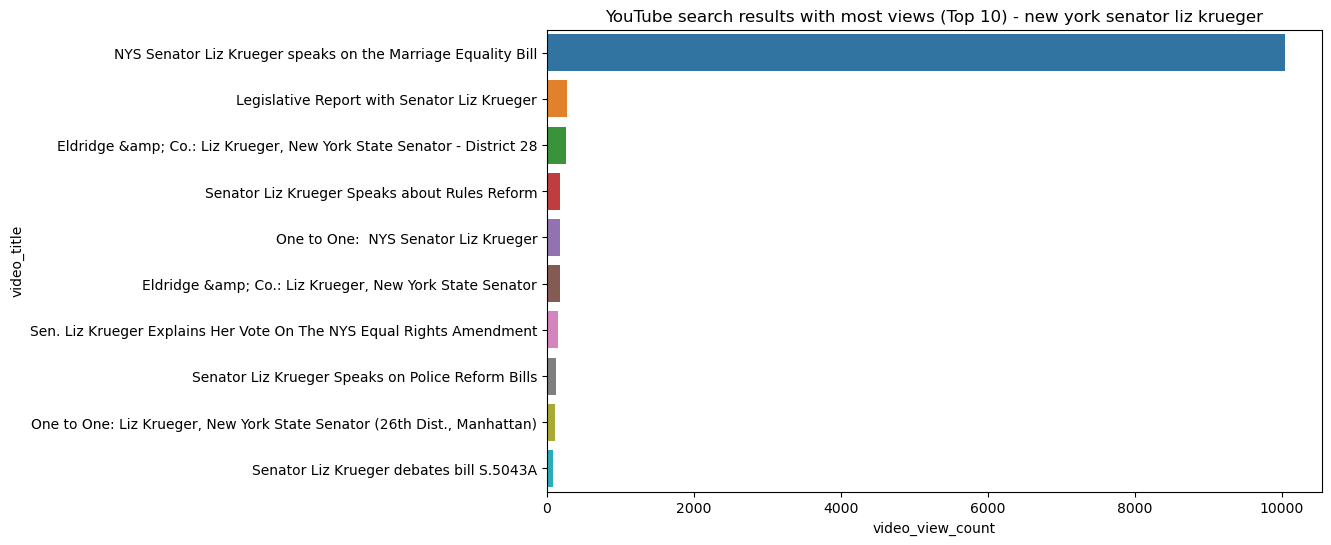

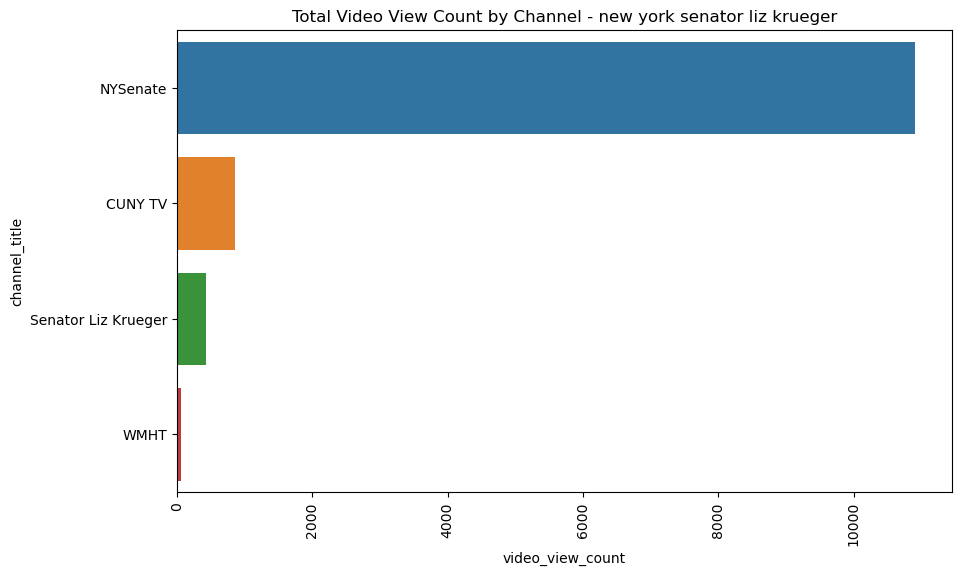

In [13]:
krueger_plots = generate_plots(search_results_df, 'new york senator liz krueger')
krueger_plots

### **Topic Modeling ([top2vec](https://top2vec.readthedocs.io/en/stable/Top2Vec.html#))**
To further leverage the data collected from the YouTube scraper, we can create a topic model from the search results. A topic model will cluster words and phrases used in similar ways over all of the video captions to specify topics. For this example we'll focus on a single politician, Florida Senator Ana Maria Rodriguez. From the output we can see there were 3 topics identified, and in the word cloud we can visualize how these words contribute the to the topic generated from our topic model. 

The 1st topic seems to be economically focused, containing keywords such as "economic", "tax", "condo" and "rent". 

The 2nd topic contains words such as "climate", "environment", "natural", "energy", "coral", "restoration" and "florida". This leads us to believe the 2nd topic environmental, and seems a bit more specific than the 1st topic. 

The 3rd topic has some conservative keywords mixing in a few environmental keywords. 

These topics were fairly accurate from the manual analysis, Rodriguez is a Republican senator from a South Florida district covering the Florida Keys. Her constituents, regardless of political affiliation, are likely impacted by the health of the environment as tourism is the most significant sector for this region. So we see that these topic models can accurately depict topics that she frequently discusses in her media appearances. Even if we had no idea where her district was located, or what her legislative agenda was, we can gain insights from these topic models that tell us her influences. 

2023-08-09 19:43:16,656 - top2vec - INFO - Pre-processing documents for training
2023-08-09 19:43:17,034 - top2vec - INFO - Creating joint document/word embedding
2023-08-09 19:43:23,871 - top2vec - INFO - Creating lower dimension embedding of documents
2023-08-09 19:43:25,026 - top2vec - INFO - Finding dense areas of documents
2023-08-09 19:43:25,029 - top2vec - INFO - Finding topics



 topic sizes:  [120  88  42]
Topic #:  0
Words: ['thats' 'affects' 'once' 'dont' 'um' 'cant' 'must' 'level' 'im' 'its'
 'help' 'tax' 'studies' 'rise' 'condo' 'need' 'like' 'gave' 'okay' 'sea'
 'west' 'rent' 'whats' 'economic' 'am' 'really' 'pay' 'saying' 'yes'
 'chamber' 'guess' 'important' 'shes' 'aspects' 'ill' 'always' 'least'
 'ive' 'office' 'fund' 'friend' 'who' 'living' 'focus' 'education'
 'industry' 'it' 'board' 'degree' 'bit']
Topic #:  1
Words: ['applause' 'climate' 'floridas' 'environment' 'gas' 'dollars' 'clean'
 'dollar' 'natural' 'wont' 'act' 'protecting' 'bay' 'forever' 'plan'
 'thousand' 'energy' 'event' 'world' 'rescue' 'teachers' 'through' 'benji'
 'conservatives' 'president' 'im' 'american' 'conservative' 'music' 'this'
 'pay' 'raises' 'sea' 'governors' 'told' 'us' 'million' 'weve' 'money'
 'need' 'administration' 'here' 'economy' 'far' 'six' 'today' 'to'
 'restoration' 'coral' 'killing']
Topic #:  2
Words: ['conservative' 'protecting' 'clean' 'natural' 'environment

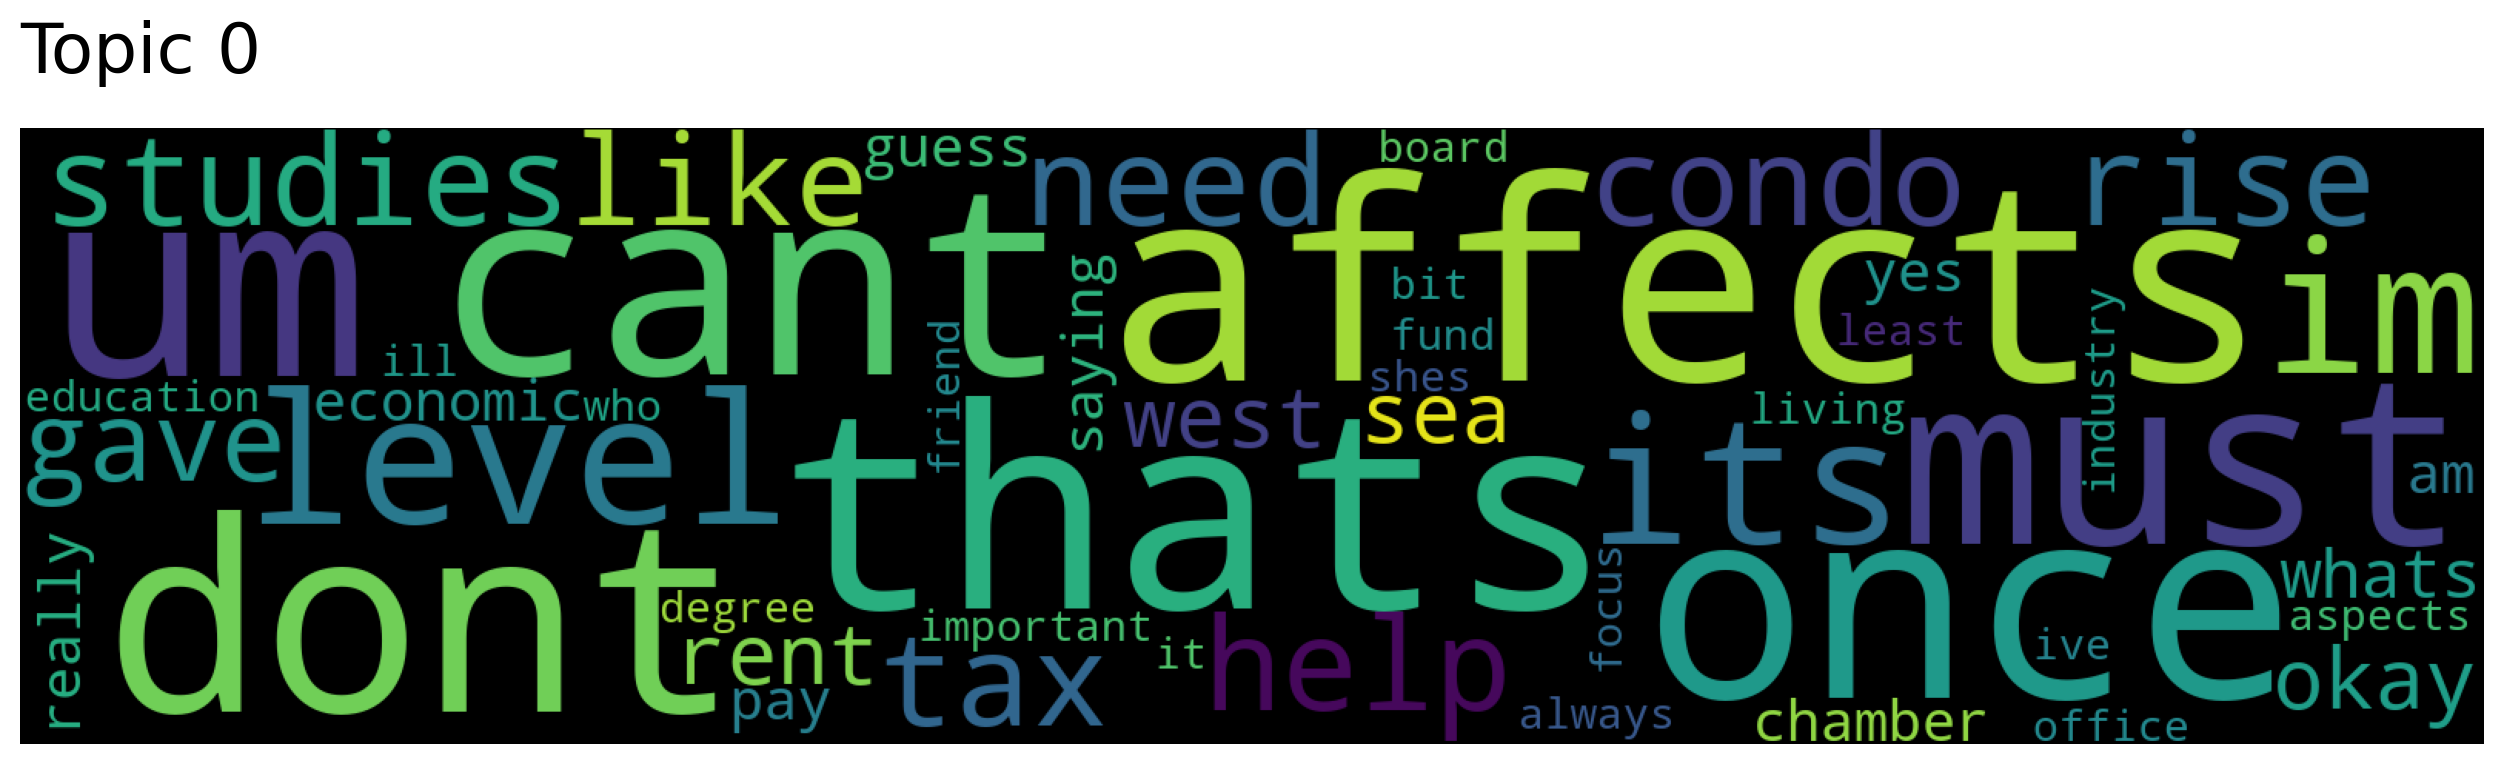

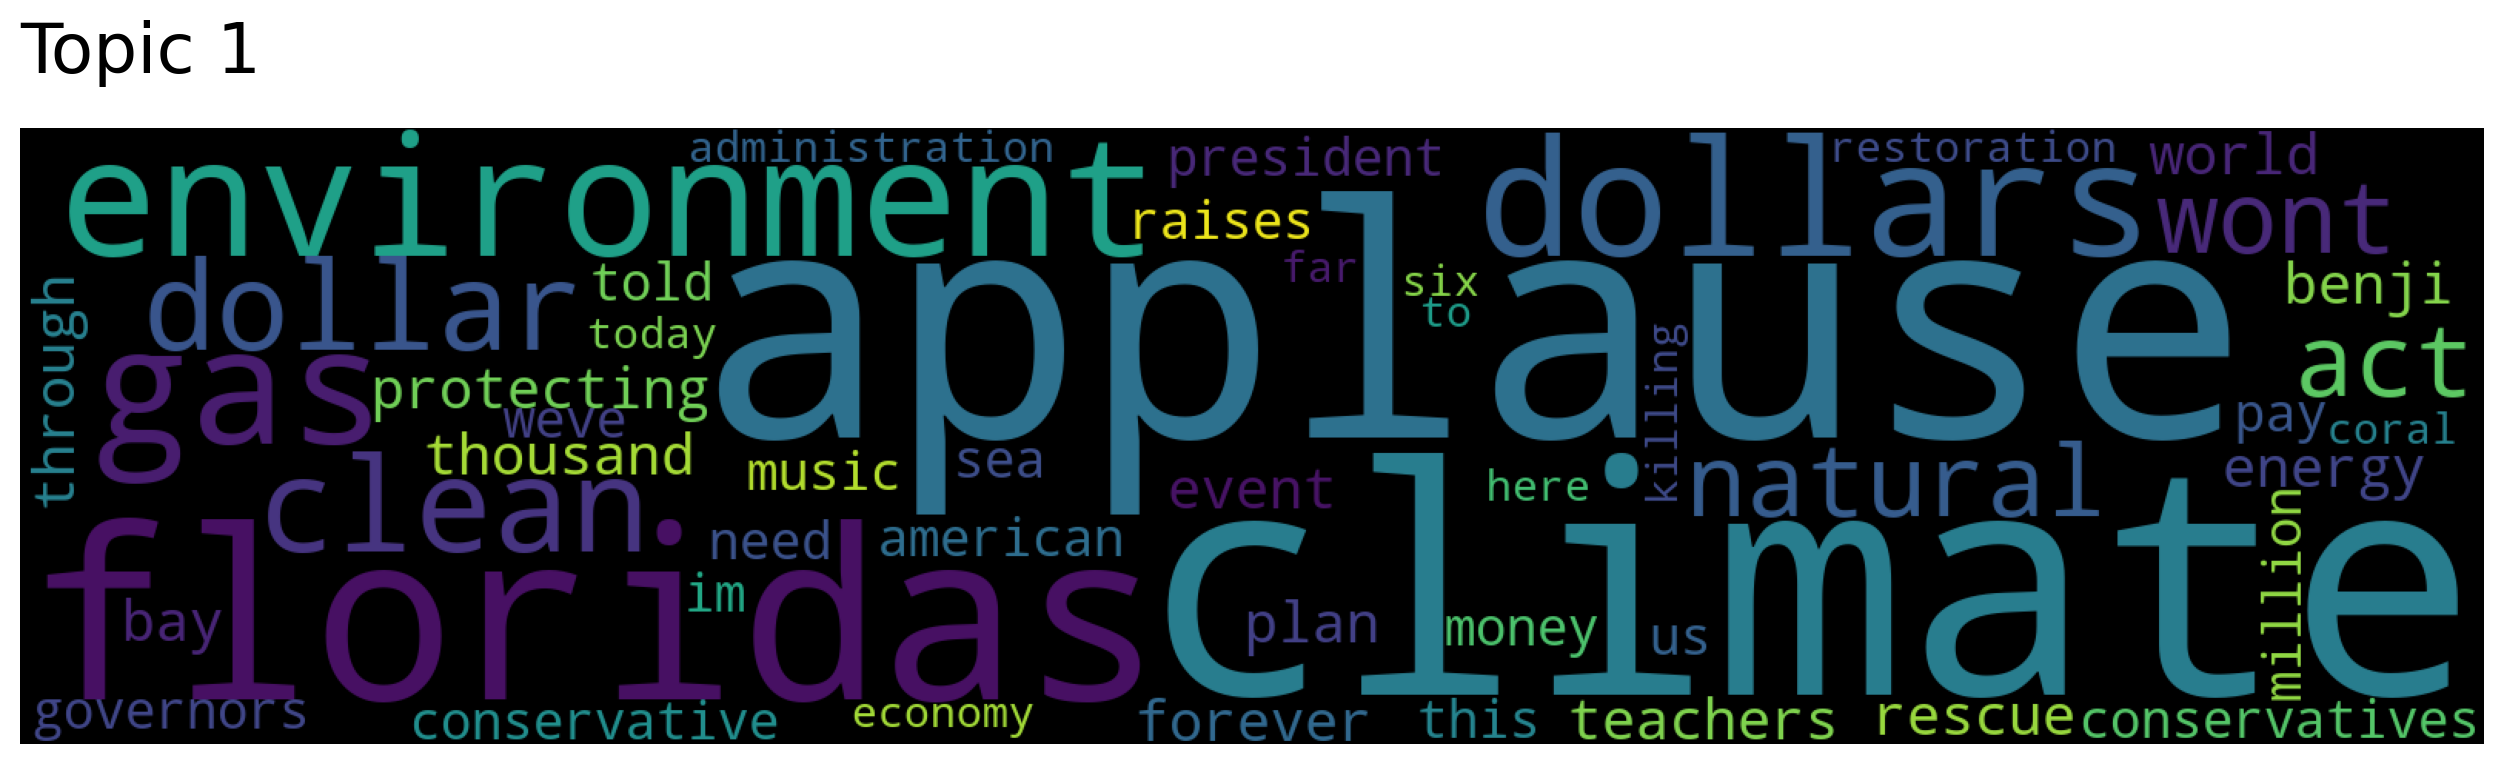

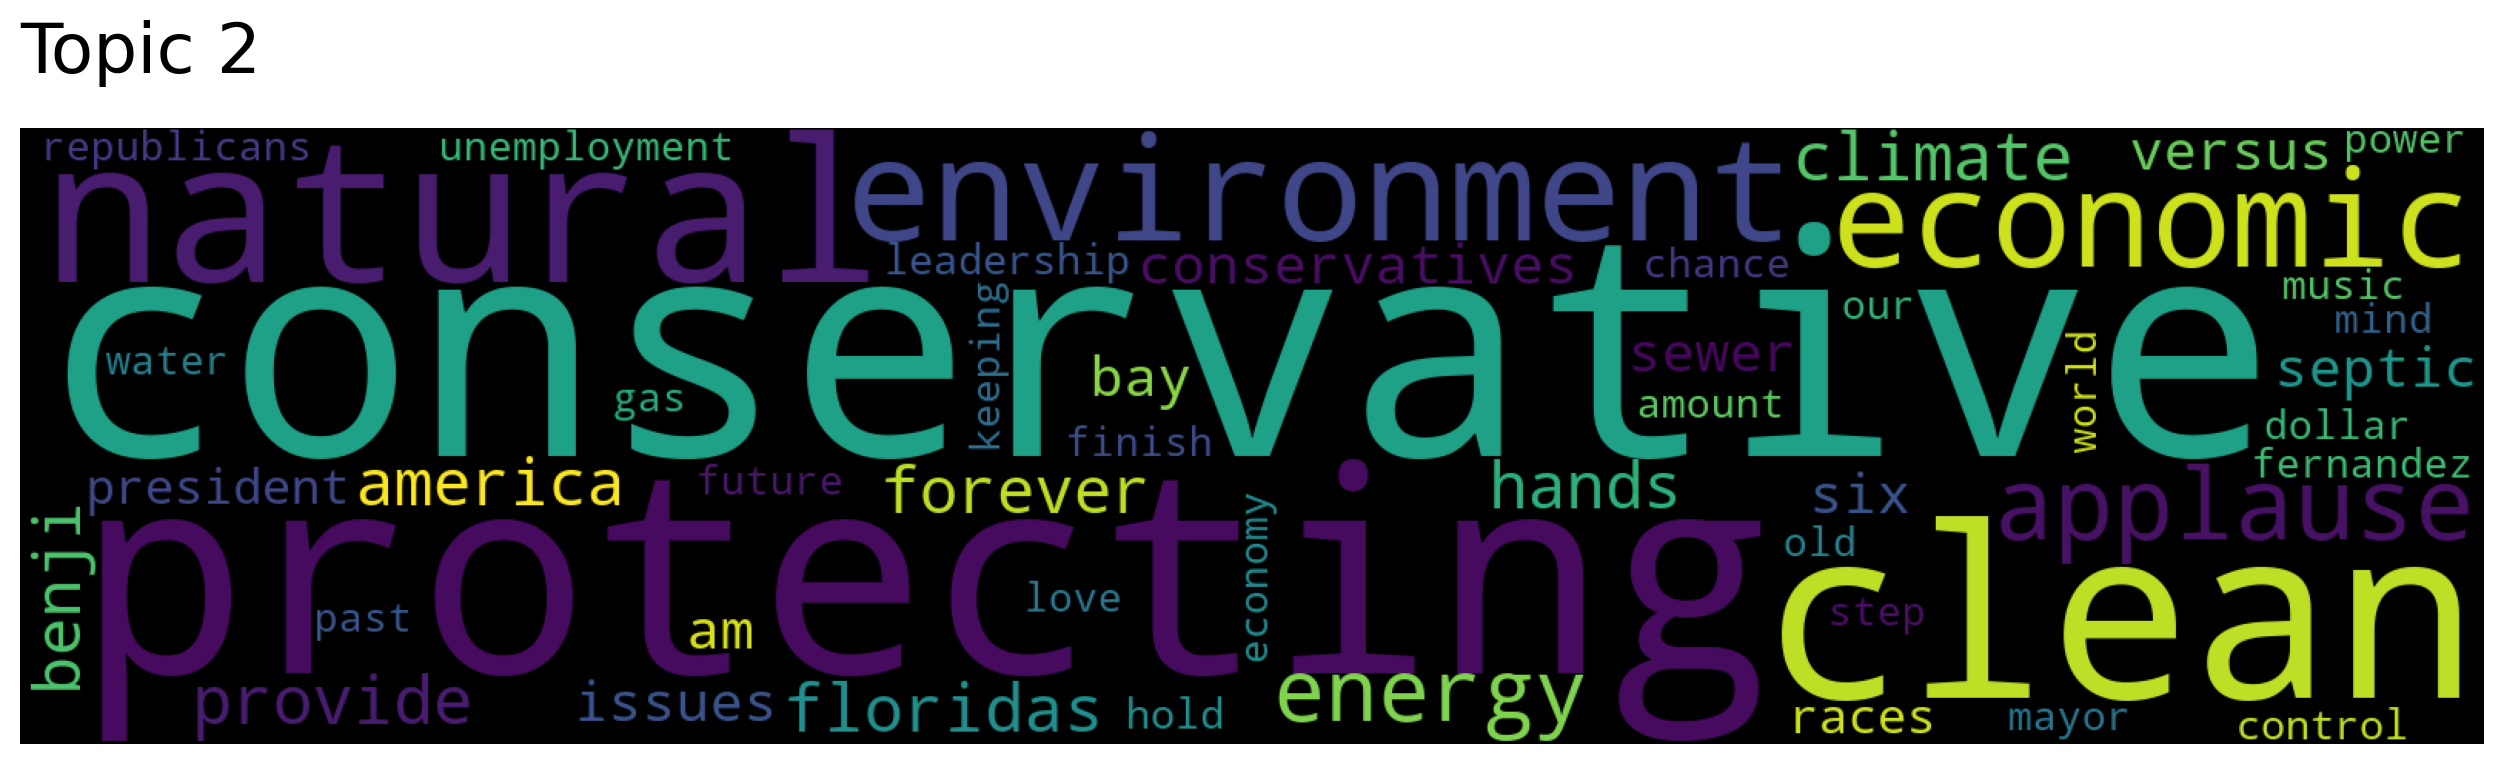

In [34]:
rodriguez_topic_ids = search_results_df[search_results_df['politician'] == 'florida senator ana maria rodriguez']['video_id']
get_topic_model(rodriguez_topic_ids, word_cloud=True)
### future development
#get_topic_model(rodriguez_topic_ids, word_cloud=True, search_keywords=['climate', 'environment'])